# SmolVLA Training with Color Augmentation
Goal: Train on episodes 0-39, validate on 40-49 with different color augmentations

why? and how? and what would be best?

**Install LeRobot**

This cell clones the `lerobot` repository from Hugging Face

In [1]:
import sys
print(sys.executable)

/home/saleh/miniforge3/envs/lerobot/bin/python


In [5]:
%cd /home/saleh/lerobot
!pip install -e . --no-deps


/home/saleh/lerobot
Obtaining file:///home/saleh/lerobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lerobot (pyproject.toml) ... done
  Created wheel for lerobot: filename=lerobot-0.4.3-0.editable-py3-none-any.whl size=15683 sha256=dd6dde7cbff1e4ebf16f6e119c44f7b033884c0d9288fdff6045ebfa9dd3828f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bjjvkrh7/wheels/e3/22/1d/b672c017bd668a3347fc4bca46a2fdbb84521bbaf9bac193de
Successfully built lerobot
  Attempting uninstall: lerobot
    Found existing installation: lerobot 0.4.3
    Uninstalling lerobot-0.4.3:
      Successfully uninstalled lerobot-0.4.3


In [ ]:
!huggingface-cli login

⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 

In [3]:
%cd /home/saleh/lerobot/
!pip install -e ".[smolvla]"

/home/saleh/lerobot
Obtaining file:///home/saleh/lerobot
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-2.7.1-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (29 kB)
Using cached torch-2.7.1-cp310-cp310-manylinux_2_28_x86_64.whl (821.2 MB)
  Building editable for lerobot (pyproject.toml) ... done
  Created wheel for lerobot: filename=lerobot-0.4.3-0.editable-py3-none-any.whl size=15683 sha256=e2034ffe31e8d190b3322b405232ee60be07b3c64e06e1d86faa2f58ed38599a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ecosz033/wheels/e3/22/1d/b672c017bd668a3347fc4bca46a2fdbb84521bbaf9bac193de
Successfully built lerobot
  Attempting uninstall: torch
    Found existing installation: torch 2.10.0a0+gitb5b5d03
    Uninstalling torch-2.10.0a0+gitb5b5d03:
      Successfully uninstalled torch-2.10.0a0+gitb5b5d03
  Attempting un

In [5]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [5]:
U = "83840e36d23dd0e6f24a11c028636d872569f17f"

In [1]:
import wandb
wandb.login()


/home/saleh/miniforge3/envs/lerobot/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/saleh/miniforge3/envs/lerobot/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

True

In [2]:
"""
SmolVLA Training with Color Augmentation Challenge
Goal: Train on episodes 0-39, validate on 40-49 with different color augmentations
"""

from pathlib import Path
import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.transforms import (
    ImageTransforms,
    ImageTransformsConfig,
    ImageTransformConfig,
)
from lerobot.policies.smolvla.modeling_smolvla import SmolVLAPolicy
from lerobot.policies.factory import make_pre_post_processors
from lerobot.policies.smolvla.configuration_smolvla import SmolVLAConfig
#Configuration
DATASET_REPO = "lerobot/svla_so101_pickplace"
OUTPUT_DIR = Path("/home/saleh/lerobot/src/lerobot_output/smolvla_proper_split_final")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BATCH_SIZE = 24
MAX_STEPS =15000
VAL_EVERY = 500


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/saleh/miniforge3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [5]:
# Weights & Biases setup
# ensure non-interactive login using saved token and allow reinit to avoid MailboxClosedError
wandb.init(
    project="First_SmolVLA_Experiment_Proper_Split_2",
    name="smolvla_split_15_final",
    config={
        "dataset": DATASET_REPO,
        "batch_size": BATCH_SIZE,
        "max_steps": MAX_STEPS,
        "train_episodes": "0-45",
        "val_episodes": "45-49",
        "video_backend": "pyav",
        "color_augmentation": "darkening, lightening, contrast, saturation",
        "model": "SmolVLA",
        "optimizer": "AdamW",
        "learning_rate": 1e-4,
        "weight_decay": 0.001,
        "lr_scheduler": "linear with warmup",
        "warmup_steps": 1000,
    },
)

In [3]:
wandb.finish()


In [4]:
import gc
import torch

# Delete old objects if they exist to free VRAM
if 'policy' in globals(): del policy
if 'optimizer' in globals(): del optimizer
if 'batch' in globals(): del batch

gc.collect()
torch.cuda.empty_cache()

In [6]:
"""
SmolVLA uses chunk_size=50 by default for action sequences
so we need to match this in our delta_timestamps configuration
"""
policy = SmolVLAPolicy.from_pretrained(
    "lerobot/smolvla_base")
policy.to(device).train()

#Extract action horizon from policy config
action_horizon = policy.config.chunk_size
print("Policy action horizon :", action_horizon)

Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...


`torch_dtype` is deprecated! Use `dtype` instead!


Reducing the number of VLM layers to 16 ...
Policy action horizon : 50


In [7]:
"""
Configure temporal structure to match SmolVLA expectations
Actions need timestamps for the full action chunk
"""
meta = LeRobotDatasetMetadata(DATASET_REPO)
fps = meta.fps
print("Dataset FPS:", fps)

# actions: 0, 1/fps, 2/fps, ..., (chunk_size-1)/fps
action_dts = [i / fps for i in range(action_horizon)]

# images & state: one timestamp
delta_timestamps = {
    "observation.state": [0.0],
    "observation.images.up": [0.0],
    "observation.images.side": [0.0],
    "action": action_dts,
}
print("Using delta_timestamps:", delta_timestamps)


Dataset FPS: 30
Using delta_timestamps: {'observation.state': [0.0], 'observation.images.up': [0.0], 'observation.images.side': [0.0], 'action': [0.0, 0.03333333333333333, 0.06666666666666667, 0.1, 0.13333333333333333, 0.16666666666666666, 0.2, 0.23333333333333334, 0.26666666666666666, 0.3, 0.3333333333333333, 0.36666666666666664, 0.4, 0.43333333333333335, 0.4666666666666667, 0.5, 0.5333333333333333, 0.5666666666666667, 0.6, 0.6333333333333333, 0.6666666666666666, 0.7, 0.7333333333333333, 0.7666666666666667, 0.8, 0.8333333333333334, 0.8666666666666667, 0.9, 0.9333333333333333, 0.9666666666666667, 1.0, 1.0333333333333334, 1.0666666666666667, 1.1, 1.1333333333333333, 1.1666666666666667, 1.2, 1.2333333333333334, 1.2666666666666666, 1.3, 1.3333333333333333, 1.3666666666666667, 1.4, 1.4333333333333333, 1.4666666666666666, 1.5, 1.5333333333333334, 1.5666666666666667, 1.6, 1.6333333333333333]}


In [8]:
"""
Load base dataset to determine train/val split
Using pyav backend due to torchcodec issues in Colab (common issue in LeRobot GitHub)
"""
print("Loading base dataset to read episode_index")
base_ds = LeRobotDataset(
    DATASET_REPO,
    video_backend="pyav",  # to avoid torchcodec issues
)
sample = base_ds[0]
print("Available keys:", list(sample.keys()))

# build 40/10 split based on episode_index
episode_idx = np.array(base_ds.hf_dataset["episode_index"])
train_indices = [i for i, ep in enumerate(episode_idx) if ep < 45]
val_indices = [i for i, ep in enumerate(episode_idx) if ep >= 45]
print(f"Found {len(train_indices)} train samples and {len(val_indices)} val samples")
print("Train indices:", train_indices)
print("Val indices:", val_indices)


Loading base dataset to read episode_index
Available keys: ['observation.images.up', 'observation.images.side', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task']
Found 10584 train samples and 1355 val samples
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165

/home/saleh/miniforge3/envs/lerobot/lib/python3.10/site-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


In [65]:
episode_idx = np.array(base_ds.hf_dataset["episode_index"])

# Define position-aware stratified split
# So101 has 5 positions × 10 episodes = 50 total
def get_position(episode_num):
    """Map episode number to cube position (0-4)"""
    return episode_num // 10

# Create stratified split: 8 train + 2 val per position
train_episodes = []
val_episodes = []

np.random.seed(42)  # For reproducibility

for position in range(5):
    # Get all episodes for this position
    position_episodes = list(range(position * 10, (position + 1) * 10))
    
    # Shuffle and split: 8 train, 2 val
    shuffled = np.random.permutation(position_episodes)
    train_episodes.extend(shuffled[:8].tolist())
    val_episodes.extend(shuffled[8:10].tolist())

# Convert episode numbers to dataset indices
train_indices = [i for i, ep in enumerate(episode_idx) if ep in train_episodes]
val_indices = [i for i, ep in enumerate(episode_idx) if ep in val_episodes]

print(f"\n{'='*60}")
print(f"STRATIFIED SPLIT ANALYSIS")
print(f"{'='*60}")
print(f"Total: {len(train_indices)} train samples, {len(val_indices)} val samples\n")

# Analyze distribution
from collections import Counter
train_ep_dist = Counter([get_position(episode_idx[i]) for i in train_indices])
val_ep_dist = Counter([get_position(episode_idx[i]) for i in val_indices])

print("Position Distribution:")
print("Pos | Train Episodes | Val Episodes | Total")
print("----|----------------|--------------|-------")
for pos in range(5):
    train_count = train_ep_dist.get(pos, 0)
    val_count = val_ep_dist.get(pos, 0)
    # Count unique episodes, not frames
    train_eps = len([ep for ep in train_episodes if get_position(ep) == pos])
    val_eps = len([ep for ep in val_episodes if get_position(ep) == pos])
    print(f"  {pos} |       {train_eps}        |      {val_eps}       |   10")

print(f"\n{'='*60}\n")

# Verify no overlap
assert len(set(train_episodes) & set(val_episodes)) == 0, "Train/val overlap detected!"
print("✓ No episode overlap between train and val sets")
print(f"✓ Train episodes: {sorted(train_indices)}")
print(f"✓ Val episodes: {sorted(val_indices)}")
print("val episodes:", val_episodes)
print(len(val_indices))


STRATIFIED SPLIT ANALYSIS
Total: 9640 train samples, 2299 val samples

Position Distribution:
Pos | Train Episodes | Val Episodes | Total
----|----------------|--------------|-------
  0 |       8        |      2       |   10
  1 |       8        |      2       |   10
  2 |       8        |      2       |   10
  3 |       8        |      2       |   10
  4 |       8        |      2       |   10


✓ No episode overlap between train and val sets
✓ Train episodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 12

In [ ]:
#IMAGE AUGMENTATIONS

train_tf_cfg = ImageTransformsConfig(
    enable=True,
    max_num_transforms=2,
    random_order=True,
    tfs={
        "brightness": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"brightness": (0.5, 1.2)}
        ),
        "contrast": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"contrast": (0.6, 1.0)}
        ),
        "saturation": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"saturation": (0.5, 1.0)}
        ),
        "hue": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"hue": (-0.05, 0.01)}
        ),
    },
)

# val slightly darker than train
val_tf_cfg = ImageTransformsConfig(
    enable=False,
    max_num_transforms=2,
    random_order=False,
    tfs={
        "brightness": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"brightness": (0.7, 1.0)}
        ),
        "contrast": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"contrast": (1.0, 1.3)}
        ),
        "saturation": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"saturation": (0.5, 1.2)}
        ),
        "hue": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"hue": (-0.08, 0.06)}
        ),
    },
)


train_tf = ImageTransforms(train_tf_cfg)
val_tf = ImageTransforms(val_tf_cfg)

print(train_tf)
print(val_tf)

ImageTransforms(
  weights=[1.0, 1.0, 1.0, 1.0]
  (tf): RandomSubsetApply(transforms=[ColorJitter(brightness=(0.5, 1.2)), ColorJitter(contrast=(0.6, 1.0)), ColorJitter(saturation=(0.5, 1.0)), ColorJitter(hue=(-0.05, 0.01))], p=[0.25, 0.25, 0.25, 0.25], n_subset=2, random_order=True)
)
ImageTransforms(
  weights=[1.0, 1.0, 1.0, 1.0]
  (tf): Identity()
)


In [33]:
test_tf_cofig = ImageTransformsConfig(
    enable=True,
    max_num_transforms=2,
    random_order=False,
    tfs={
        "brightness": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"brightness": (0.7, 1.0)}
        ),
        "contrast": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"contrast": (1.0, 1.3)}
        ),
        "saturation": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"saturation": (0.5, 1.2)}
        ),
        "hue": ImageTransformConfig(
            weight=1.0, type="ColorJitter", kwargs={"hue": (-0.06, 0.06)}
        ),
    },
)
test_tf = ImageTransforms(test_tf_cofig)
print(test_tf)


ImageTransforms(
  weights=[1.0, 1.0, 1.0, 1.0]
  (tf): RandomSubsetApply(transforms=[ColorJitter(brightness=(0.7, 1.0)), ColorJitter(contrast=(1.0, 1.3)), ColorJitter(saturation=(0.5, 1.2)), ColorJitter(hue=(-0.06, 0.06))], p=[0.25, 0.25, 0.25, 0.25], n_subset=2, random_order=False)
)


In [40]:
"""
Create separate datasets train/val with different augmentations
Then apply episode-based splits using Subset
"""

train_full = LeRobotDataset(
    DATASET_REPO,
    delta_timestamps=delta_timestamps,
    image_transforms=train_tf,
    video_backend="pyav",
)

val_full = LeRobotDataset(
    DATASET_REPO,
    delta_timestamps=delta_timestamps,
    image_transforms=val_tf,
    video_backend="pyav",
)
test_full = LeRobotDataset(
    DATASET_REPO,
    delta_timestamps=delta_timestamps,
    image_transforms=test_tf,
    video_backend="pyav",
)

# final split
train_ds = Subset(train_full, train_indices)
val_ds = Subset(val_full, val_indices)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")


Train: 9640, Val: 2299


In [41]:
"""Create efficient data loading with proper settings"""

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=8  # Reduced for Colab stability
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=8
)


In [23]:
"""Setup data preprocessing and optimisation"""
from lerobot.optim.optimizers import AdamWConfig

#create preprocessors using dataset stat
preprocessor, postprocessor = make_pre_post_processors(
    policy.config,
    dataset_stats=meta.stats,
)
print("pre:", preprocessor)
optimizer = policy.config.get_optimizer_preset().build(policy.parameters())
print("Optimizer:", optimizer)

optimizer2 = AdamWConfig()
print(optimizer2)

pre: DataProcessorPipeline(name='policy_preprocessor', steps=6: [RenameObservationsProcessorStep, AddBatchDimensionProcessorStep, ..., NormalizerProcessorStep])
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-10
)
AdamWConfig(lr=0.001, weight_decay=0.01, grad_clip_norm=10.0, betas=(0.9, 0.999), eps=1e-08)


In [24]:
import os
# Must be set before importing transformers/torch
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [25]:
"""Setup data preprocessing and optimisation"""
from lerobot.optim.optimizers import AdamWConfig

# create preprocessors using dataset stat
preprocessor, postprocessor = make_pre_post_processors(
    policy.config,
    dataset_stats=meta.stats,
)
print("pre:", preprocessor)

# --- CHANGED SECTION STARTS HERE ---

# 1. Get the default configuration first (don't build yet)
opt_config = policy.config.get_optimizer_preset()

# 2. Manually override the weight_decay
# We change it from the default (1e-10) to 1e-2 (0.01) to fix overfitting
opt_config.weight_decay = 0.01

# 3. Now build the optimizer with your NEW settings
optimizer = opt_config.build(policy.parameters())

# --- CHANGED SECTION ENDS HERE ---

print("Optimizer:", optimizer)

pre: DataProcessorPipeline(name='policy_preprocessor', steps=6: [RenameObservationsProcessorStep, AddBatchDimensionProcessorStep, ..., NormalizerProcessorStep])
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)


In [26]:
import warnings
# Suppress the specific torchvision video warning
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.io")

In [27]:
#Helper Functions

def fix_keys(batch: dict) -> dict:
    """
    Fix camera naming convention
    SmolVLA expects camera1/camera2, dataset provides up/side
    """
    if "observation.images.up" in batch:
        batch["observation.images.camera1"] = batch.pop("observation.images.up")
    if "observation.images.side" in batch:
        batch["observation.images.camera2"] = batch.pop("observation.images.side")

    return batch


In [28]:
print("Setup complete. Ready for training loop.")
print()
print(f"The optimizer: {optimizer} weight decay is set to: {optimizer.defaults['weight_decay']}")


Setup complete. Ready for training loop.

The optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
) weight decay is set to: 0.01


In [45]:
# Main training loop - step-based to resume whenever Colab runtime crashes

best_val = float("inf")
step = 0
CKPT_EVERY = 1000
LOG_EVERY = 100
print(f"Starting training for {MAX_STEPS} steps...")

while step < MAX_STEPS:
    for raw_batch in train_loader:
        # 1 normalize
        raw_batch = fix_keys(raw_batch)

        # 2 run preprocessor
        batch = preprocessor(raw_batch)

        # 3 move tensors to GPU
        for k, v in list(batch.items()):
            if torch.is_tensor(v):
                batch[k] = v.to(device, non_blocking=True)

        # 4) forward
        out = policy.forward(batch)
        if isinstance(out, tuple):
            loss = out[0]
        else:
            loss = out["loss"]

        # 5 backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 6 logging
        if step % LOG_EVERY == 0:
            print(f"[step {step}] train loss = {loss.item():.4f}")
            wandb.log({"train/loss": loss.item(), "step": step})

        # 7 validation
        if step > 0 and step % VAL_EVERY == 0:
            policy.eval()
            val_losses = []
            with torch.no_grad():
                for i, vraw in enumerate(val_loader):
                    if i >= 50:  # keep val short
                        break

                    vraw = fix_keys(vraw)
                    vbatch = preprocessor(vraw)

                    for k, v in list(vbatch.items()):
                        if torch.is_tensor(v):
                            vbatch[k] = v.to(device, non_blocking=True)

                    vout = policy.forward(vbatch)
                    if isinstance(vout, tuple):
                        vloss = vout[0].item()
                    else:
                        vloss = vout["loss"].item()

                    val_losses.append(vloss)

            val_loss = sum(val_losses) / len(val_losses)
            print(f"[step {step}] val loss = {val_loss:.4f}")
            wandb.log({"val/loss": val_loss, "step": step})


            # sometimes earlier checkpoints generalise better, so we keep the best val
            if val_loss < best_val:
                best_val = val_loss
                best_dir = OUTPUT_DIR / "best_model"
                best_dir.mkdir(parents=True, exist_ok=True)
                policy.save_pretrained(best_dir)
                preprocessor.save_pretrained(best_dir)
                postprocessor.save_pretrained(best_dir)
                print("new best model saved")

            policy.train()

        # 8 checkpoint every 1k step
        if step > 0 and step % CKPT_EVERY == 0:
            ckpt_dir = OUTPUT_DIR / f"checkpoint-{step}"
            ckpt_dir.mkdir(exist_ok=True)
            policy.save_pretrained(ckpt_dir)
            preprocessor.save_pretrained(ckpt_dir)
            postprocessor.save_pretrained(ckpt_dir)
            print(f"Checkpoint saved at {ckpt_dir}")

        step += 1
        if step >= MAX_STEPS:
            break

#9 FINAL SAVE
policy.save_pretrained(OUTPUT_DIR)
preprocessor.save_pretrained(OUTPUT_DIR)
postprocessor.save_pretrained(OUTPUT_DIR)
wandb.finish()
print(f"Done. Best val loss = {best_val:.4f}")

Starting training for 15000 steps...
[step 0] train loss = 0.1519
[step 100] train loss = 0.0617
[step 200] train loss = 0.0586
[step 300] train loss = 0.0389
[step 400] train loss = 0.0360
[step 500] train loss = 0.0390
[step 500] val loss = 0.0463
new best model saved
[step 600] train loss = 0.0378
[step 700] train loss = 0.0306
[step 800] train loss = 0.0385
[step 900] train loss = 0.0394
[step 1000] train loss = 0.0350
[step 1000] val loss = 0.0484
Checkpoint saved at /home/saleh/lerobot/src/lerobot_output/smolvla_proper_split_final/checkpoint-1000
[step 1100] train loss = 0.0317
[step 1200] train loss = 0.0358
[step 1300] train loss = 0.0267
[step 1400] train loss = 0.0315
[step 1500] train loss = 0.0293
[step 1500] val loss = 0.0430
new best model saved
[step 1600] train loss = 0.0341
[step 1700] train loss = 0.0491
[step 1800] train loss = 0.0587
[step 1900] train loss = 0.0295
[step 2000] train loss = 0.0260
[step 2000] val loss = 0.0391
new best model saved
Checkpoint saved at

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▁▃▁▂▁▁▁▁▁▁▁▁▁▁
val/loss,▇█▅▃▆▂▄▂▁▃▂▁▃▂▄▄▅▄▄▅▄▄▅▅▅▅▅▅▆
step,14900
train/loss,0.01436
val/loss,0.0442


Done. Best val loss = 0.0360


In [29]:
batch = next(iter(train_loader))
imgs = batch["observation.images.up"]
print(f"Min value: {imgs.min().item():.3f}")
print(f"Max value: {imgs.max().item():.3f}")
print(f"Mean value: {imgs.mean().item():.3f}")

Min value: 0.000
Max value: 0.971
Mean value: 0.498


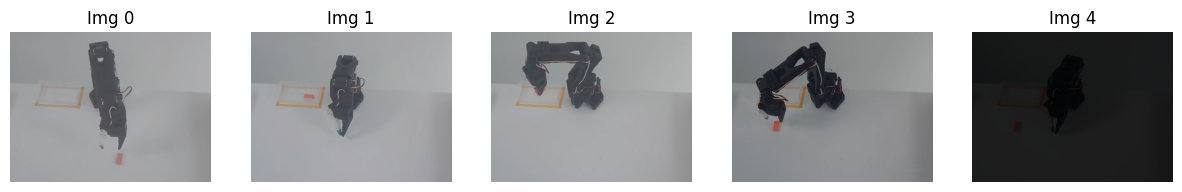

In [22]:
import matplotlib.pyplot as plt

# 1. Get one batch
batch = next(iter(train_loader))
imgs = batch["observation.images.up"] # Shape: (Batch, C, H, W)

# 2. Plot directly (No un-normalization needed for 0-1 data)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Permute to (H, W, C) for matplotlib
    img_np = imgs[i].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"Img {i}")
    axes[i].axis("off")

plt.show()

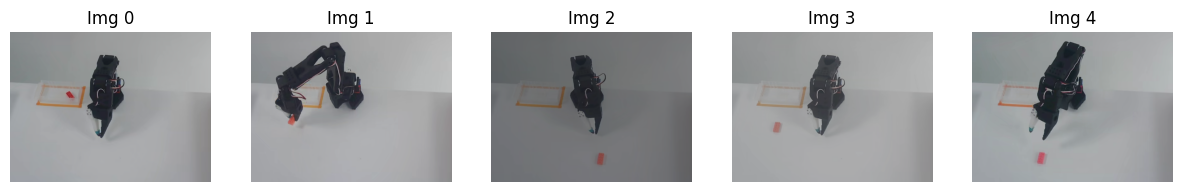

In [23]:
import matplotlib.pyplot as plt

# 1. Get one batch
batch = next(iter(train_loader))
imgs = batch["observation.images.up"] # Shape: (Batch, C, H, W)

# 2. Plot directly (No un-normalization needed for 0-1 data)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Permute to (H, W, C) for matplotlib
    img_np = imgs[i].permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img_np)
    axes[i].set_title(f"Img {i}")
    axes[i].axis("off")

plt.show()

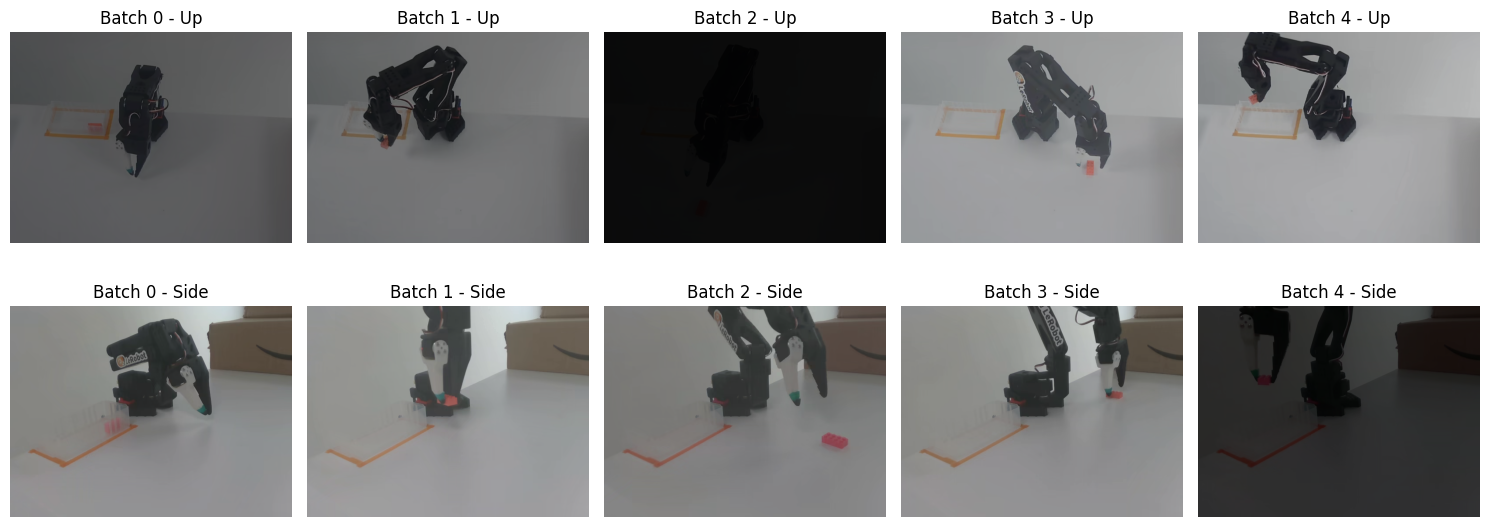

In [30]:
import matplotlib.pyplot as plt

# 1. Get one batch
batch = next(iter(train_loader))
imgs_up = batch["observation.images.up"]      # Shape: (Batch, C, H, W)
imgs_side = batch["observation.images.side"]  # Shape: (Batch, C, H, W)

# 2. Setup Plot: 2 Rows (one for each camera), 5 Columns (one for each item in batch)
# figsize is (width, height) -> increased height to fit two rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 

for i in range(5):
    # --- Plot UP Camera (Row 0) ---
    img_up_np = imgs_up[i].permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(img_up_np)
    axes[0, i].set_title(f"Batch {i} - Up")
    axes[0, i].axis("off")

    # --- Plot SIDE Camera (Row 1) ---
    img_side_np = imgs_side[i].permute(1, 2, 0).cpu().numpy()
    axes[1, i].imshow(img_side_np)
    axes[1, i].set_title(f"Batch {i} - Side")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

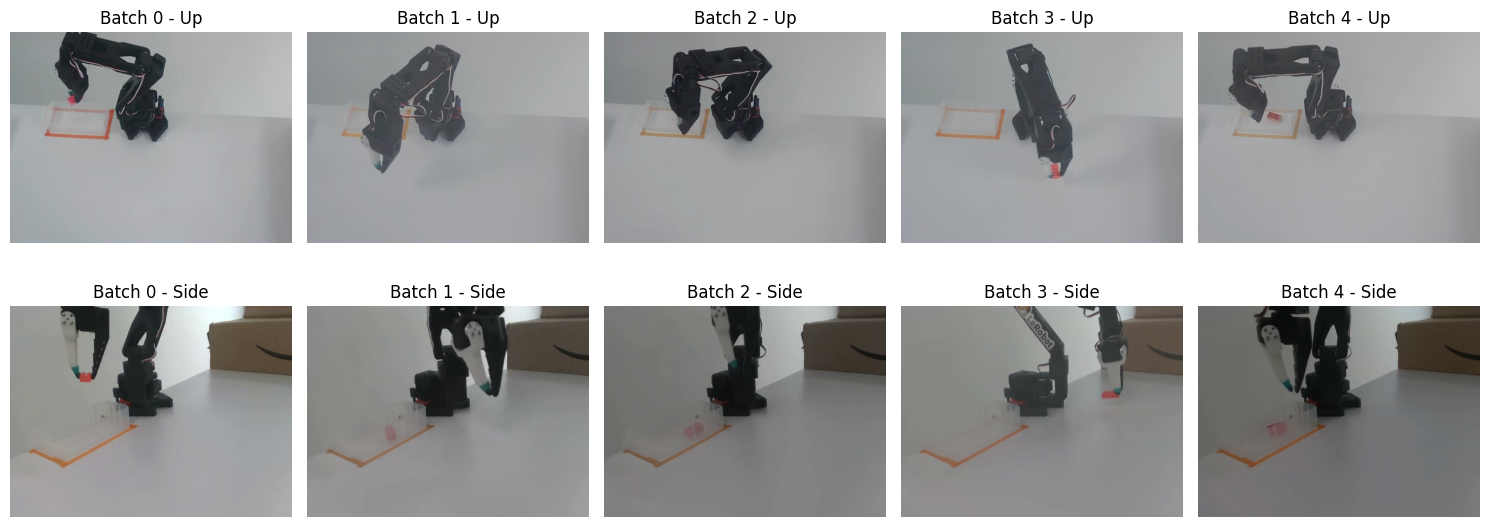

In [44]:
import matplotlib.pyplot as plt

# 1. Get one batch
batch = next(iter(train_loader))
imgs_up = batch["observation.images.up"]      # Shape: (Batch, C, H, W)
imgs_side = batch["observation.images.side"]  # Shape: (Batch, C, H, W)

# 2. Setup Plot: 2 Rows (one for each camera), 5 Columns (one for each item in batch)
# figsize is (width, height) -> increased height to fit two rows
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 

for i in range(5):
    # --- Plot UP Camera (Row 0) ---
    img_up_np = imgs_up[i].permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(img_up_np)
    axes[0, i].set_title(f"Batch {i} - Up")
    axes[0, i].axis("off")

    # --- Plot SIDE Camera (Row 1) ---
    img_side_np = imgs_side[i].permute(1, 2, 0).cpu().numpy()
    axes[1, i].imshow(img_side_np)
    axes[1, i].set_title(f"Batch {i} - Side")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

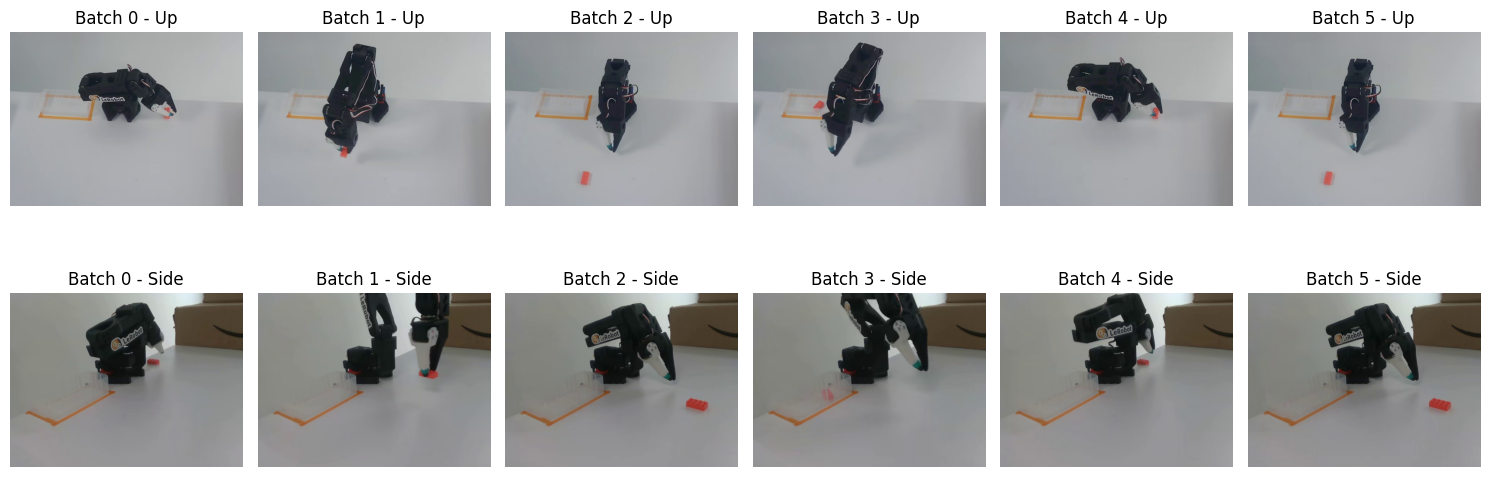

In [31]:
import matplotlib.pyplot as plt

# 1. Get one batch
batch = next(iter(val_loader))
imgs_up = batch["observation.images.up"]      # Shape: (Batch, C, H, W)
imgs_side = batch["observation.images.side"]  # Shape: (Batch, C, H, W)

# 2. Setup Plot: 2 Rows (one for each camera), 5 Columns (one for each item in batch)
# figsize is (width, height) -> increased height to fit two rows
fig, axes = plt.subplots(2, 6, figsize=(15, 6)) 

for i in range(6):
    # --- Plot UP Camera (Row 0) ---
    img_up_np = imgs_up[i].permute(1, 2, 0).cpu().numpy()
    axes[0, i].imshow(img_up_np)
    axes[0, i].set_title(f"Batch {i} - Up")
    axes[0, i].axis("off")

    # --- Plot SIDE Camera (Row 1) ---
    img_side_np = imgs_side[i].permute(1, 2, 0).cpu().numpy()
    axes[1, i].imshow(img_side_np)
    axes[1, i].set_title(f"Batch {i} - Side")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [60]:
episode_ix = np.array(base_ds.hf_dataset["episode_index"])
    
print(episode_ix)

[ 0  0  0 ... 49 49 49]


In [63]:
VAL_EPISODES = [3, 6, 16, 12, 21, 24, 35, 39, 42, 49]
val_indices = [i for i, ep in enumerate(episode_idx) if ep in VAL_EPISODES]

val_full = LeRobotDataset(
    DATASET_REPO,
    delta_timestamps=delta_timestamps,
    video_backend="pyav",
)
val_ds = Subset(val_full, val_indices)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print(f"val samples: {len(val_ds)}")

val samples: 2299


In [66]:
action_stats = meta.stats["action"]
action_min = torch.tensor(action_stats["min"])
action_max = torch.tensor(action_stats["max"])
action_mean = torch.tensor(action_stats["mean"])
action_std  = torch.tensor(action_stats["std"])

def unnormalize_pred(pred_norm: torch.Tensor) -> torch.Tensor:
    """Model outputs normalized actions (because training loss was on normalized), so map back to dataset space using mean/std from meta.stats"""
    return pred_norm * action_std + action_mean

In [71]:
# Enhanced evaluation with multiple metrics
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(DEVICE).eval()

import matplotlib.pyplot as plt
from collections import defaultdict

all_preds_raw = []
all_gts_raw = []
episode_metrics = defaultdict(list)  # Track per-episode performance

with torch.no_grad():
    for i, raw in enumerate(val_loader):
        # Ground truth in RAW space (dataset space)
        gt_raw = raw["action"][:, 0, :].clone()  # (B,6)
        
        # Track which episode each sample belongs to
        batch_episodes = raw["episode_index"]  # (B,)
        
        raw = fix_keys(raw)
        batch = preprocessor(raw)

        for k, v in list(batch.items()):
            if torch.is_tensor(v):
                batch[k] = v.to(DEVICE)

        # Model inference
        pred_seq = policy.predict_action_chunk(batch)  # (B, 50, 6)
        pred_step0 = pred_seq[:, 0, :].cpu()           # (B,6) normalized

        # Unnormalize to RAW space
        pred_raw = unnormalize_pred(pred_step0)  # (B,6)
        
        # Track per-episode errors
        for j in range(len(gt_raw)):
            ep = batch_episodes[j].item()
            error = torch.abs(pred_raw[j] - gt_raw[j])
            episode_metrics[ep].append(error)
        
        all_preds_raw.append(pred_raw)
        all_gts_raw.append(gt_raw)

all_preds_raw = torch.cat(all_preds_raw, dim=0)
all_gts_raw = torch.cat(all_gts_raw, dim=0)

print("✓ Collected preds:", all_preds_raw.shape, "Ground truths:", all_gts_raw.shape)

✓ Collected preds: torch.Size([2299, 6]) Ground truths: torch.Size([2299, 6])


In [72]:
# ========== MULTIPLE EVALUATION METRICS ==========

joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll', 'gripper']
joint_ranges = action_max - action_min

print("\n" + "="*70)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*70)

# 1. Mean Absolute Error (MAE)
mae_per_joint = torch.abs(all_preds_raw - all_gts_raw).mean(dim=0)
mae_overall = mae_per_joint.mean().item()

print(f"\n{'MEAN ABSOLUTE ERROR (MAE)':-^70}")
print(f"{'Joint':<20} {'MAE (radians)':>15} {'% of Range':>15}")
print("-" * 70)
for i, name in enumerate(joint_names):
    mae = mae_per_joint[i].item()
    pct = (mae / joint_ranges[i].item()) * 100
    print(f"{name:<20} {mae:>15.4f} {pct:>14.2f}%")
print(f"{'AVERAGE':<20} {mae_overall:>15.4f}")

# 2. Root Mean Square Error (RMSE)
rmse_per_joint = torch.sqrt(((all_preds_raw - all_gts_raw)**2).mean(dim=0))
rmse_overall = rmse_per_joint.mean().item()

print(f"\n{'ROOT MEAN SQUARE ERROR (RMSE)':-^70}")
print(f"{'Joint':<20} {'RMSE (radians)':>15} {'% of Range':>15}")
print("-" * 70)
for i, name in enumerate(joint_names):
    rmse = rmse_per_joint[i].item()
    pct = (rmse / joint_ranges[i].item()) * 100
    print(f"{name:<20} {rmse:>15.4f} {pct:>14.2f}%")
print(f"{'AVERAGE':<20} {rmse_overall:>15.4f}")

# 3. Success Rate (within 5% of range)
tol_5pct = joint_ranges * 0.05
abs_err = torch.abs(all_preds_raw - all_gts_raw)
within_5pct = abs_err <= tol_5pct

per_joint_success = within_5pct.float().mean(dim=0) * 100.0
overall_success = per_joint_success.mean().item()

print(f"\n{'SUCCESS RATE (within 5% of joint range)':-^70}")
print(f"{'Joint':<20} {'Success Rate':>15} {'Tolerance':>15}")
print("-" * 70)
for i, name in enumerate(joint_names):
    success = per_joint_success[i].item()
    tol = tol_5pct[i].item()
    print(f"{name:<20} {success:>14.2f}% {tol:>14.4f} rad")
print(f"{'AVERAGE':<20} {overall_success:>14.2f}%")

# 4. Max Errors
max_err_per_joint = abs_err.max(dim=0)[0]

print(f"\n{'MAXIMUM ERRORS':-^70}")
print(f"{'Joint':<20} {'Max Error (rad)':>15} {'% of Range':>15}")
print("-" * 70)
for i, name in enumerate(joint_names):
    max_err = max_err_per_joint[i].item()
    pct = (max_err / joint_ranges[i].item()) * 100
    print(f"{name:<20} {max_err:>15.4f} {pct:>14.2f}%")

print("\n" + "="*70)

# 5. Overall Assessment
print(f"\n{'OVERALL ASSESSMENT':-^70}")
if mae_overall < 0.05:
    status = "🏆 EXCELLENT"
    desc = "Predictions are very accurate!"
elif mae_overall < 0.10:
    status = "✓ GOOD"
    desc = "Predictions are reasonably accurate."
elif mae_overall < 0.15:
    status = "⚠ FAIR"
    desc = "Predictions have moderate errors."
else:
    status = "❌ POOR"
    desc = "Predictions have significant errors."

print(f"{status}: MAE = {mae_overall:.4f} radians")
print(f"{desc}")
print(f"Success rate (5% tolerance): {overall_success:.1f}%")
print("="*70 + "\n")


COMPREHENSIVE EVALUATION RESULTS

----------------------MEAN ABSOLUTE ERROR (MAE)-----------------------
Joint                  MAE (radians)      % of Range
----------------------------------------------------------------------
shoulder_pan                  2.5030           1.38%
shoulder_lift                 3.0797           2.85%
elbow_flex                    2.4334           2.80%
wrist_flex                    1.9643           2.98%
wrist_roll                    1.1518           1.58%
gripper                       1.2489           3.78%
AVERAGE                       2.0635

--------------------ROOT MEAN SQUARE ERROR (RMSE)---------------------
Joint                 RMSE (radians)      % of Range
----------------------------------------------------------------------
shoulder_pan                  3.3736           1.86%
shoulder_lift                 5.0072           4.63%
elbow_flex                    3.3587           3.86%
wrist_flex                    2.9876           4.53%
wrist_r

In [73]:
# Per-episode performance breakdown
print("\n" + "="*70)
print("PER-EPISODE PERFORMANCE")
print("="*70)

episode_maes = {}
for ep in sorted(val_episodes):
    if ep in episode_metrics:
        errors = torch.stack(episode_metrics[ep])
        ep_mae = errors.mean().item()
        episode_maes[ep] = ep_mae
        
        # Identify position
        position = ep // 10
        print(f"Episode {ep:2d} (Position {position}): MAE = {ep_mae:.4f}")

print("\n" + "="*70)

# Position-wise analysis
print("\nPER-POSITION PERFORMANCE:")
position_maes = defaultdict(list)
for ep, mae in episode_maes.items():
    pos = ep // 10
    position_maes[pos].append(mae)

for pos in range(5):
    if pos in position_maes:
        avg_mae = np.mean(position_maes[pos])
        print(f"Position {pos}: Average MAE = {avg_mae:.4f} ({len(position_maes[pos])} episodes)")


PER-EPISODE PERFORMANCE
Episode  3 (Position 0): MAE = 1.9731
Episode  6 (Position 0): MAE = 1.7896
Episode 12 (Position 1): MAE = 2.5766
Episode 16 (Position 1): MAE = 1.7582
Episode 21 (Position 2): MAE = 1.7444
Episode 24 (Position 2): MAE = 1.7494
Episode 35 (Position 3): MAE = 1.7844
Episode 39 (Position 3): MAE = 1.8595
Episode 42 (Position 4): MAE = 2.5773
Episode 49 (Position 4): MAE = 2.6526


PER-POSITION PERFORMANCE:
Position 0: Average MAE = 1.8813 (2 episodes)
Position 1: Average MAE = 2.1674 (2 episodes)
Position 2: Average MAE = 1.7469 (2 episodes)
Position 3: Average MAE = 1.8219 (2 episodes)
Position 4: Average MAE = 2.6149 (2 episodes)


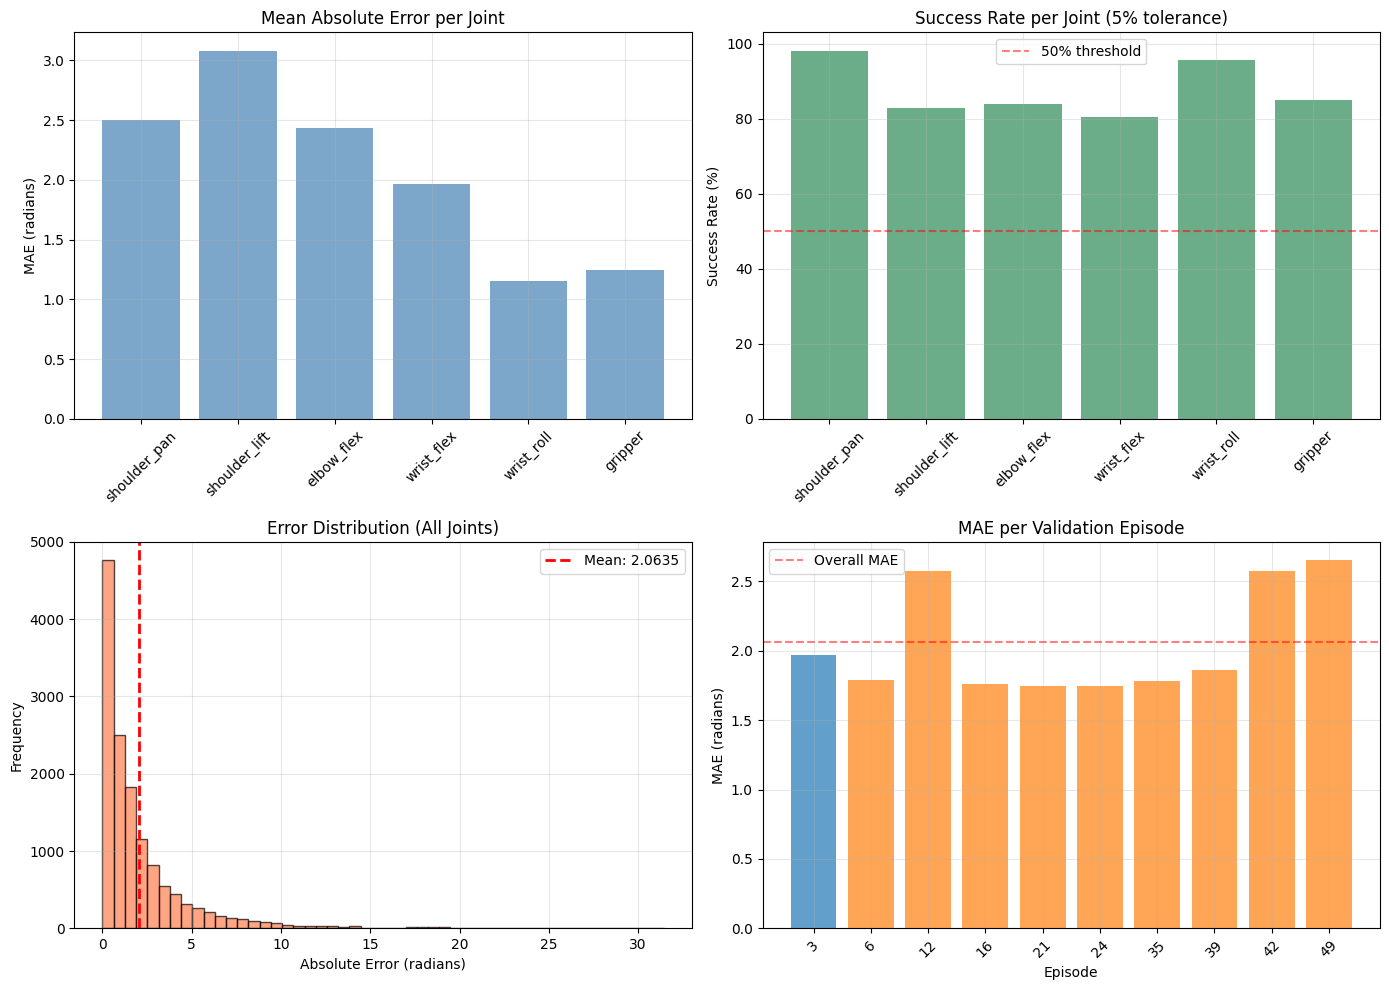


✓ Visualizations saved to 'evaluation_results.png'


In [74]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. MAE per joint
axes[0, 0].bar(joint_names, mae_per_joint.numpy(), color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('MAE (radians)')
axes[0, 0].set_title('Mean Absolute Error per Joint')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Success rate per joint
axes[0, 1].bar(joint_names, per_joint_success.numpy(), color='seagreen', alpha=0.7)
axes[0, 1].set_ylabel('Success Rate (%)')
axes[0, 1].set_title('Success Rate per Joint (5% tolerance)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Error distribution histogram
all_errors_flat = abs_err.flatten().numpy()
axes[1, 0].hist(all_errors_flat, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Absolute Error (radians)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution (All Joints)')
axes[1, 0].axvline(x=mae_overall, color='red', linestyle='--', linewidth=2, label=f'Mean: {mae_overall:.4f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Per-episode MAE
if episode_maes:
    episodes = sorted(episode_maes.keys())
    maes = [episode_maes[ep] for ep in episodes]
    colors = ['C0' if ep//10 == i else 'C1' for i, ep in enumerate(episodes)]
    
    axes[1, 1].bar(range(len(episodes)), maes, color=colors, alpha=0.7)
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('MAE (radians)')
    axes[1, 1].set_title('MAE per Validation Episode')
    axes[1, 1].set_xticks(range(len(episodes)))
    axes[1, 1].set_xticklabels(episodes, rotation=45)
    axes[1, 1].axhline(y=mae_overall, color='red', linestyle='--', alpha=0.5, label='Overall MAE')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualizations saved to 'evaluation_results.png'")

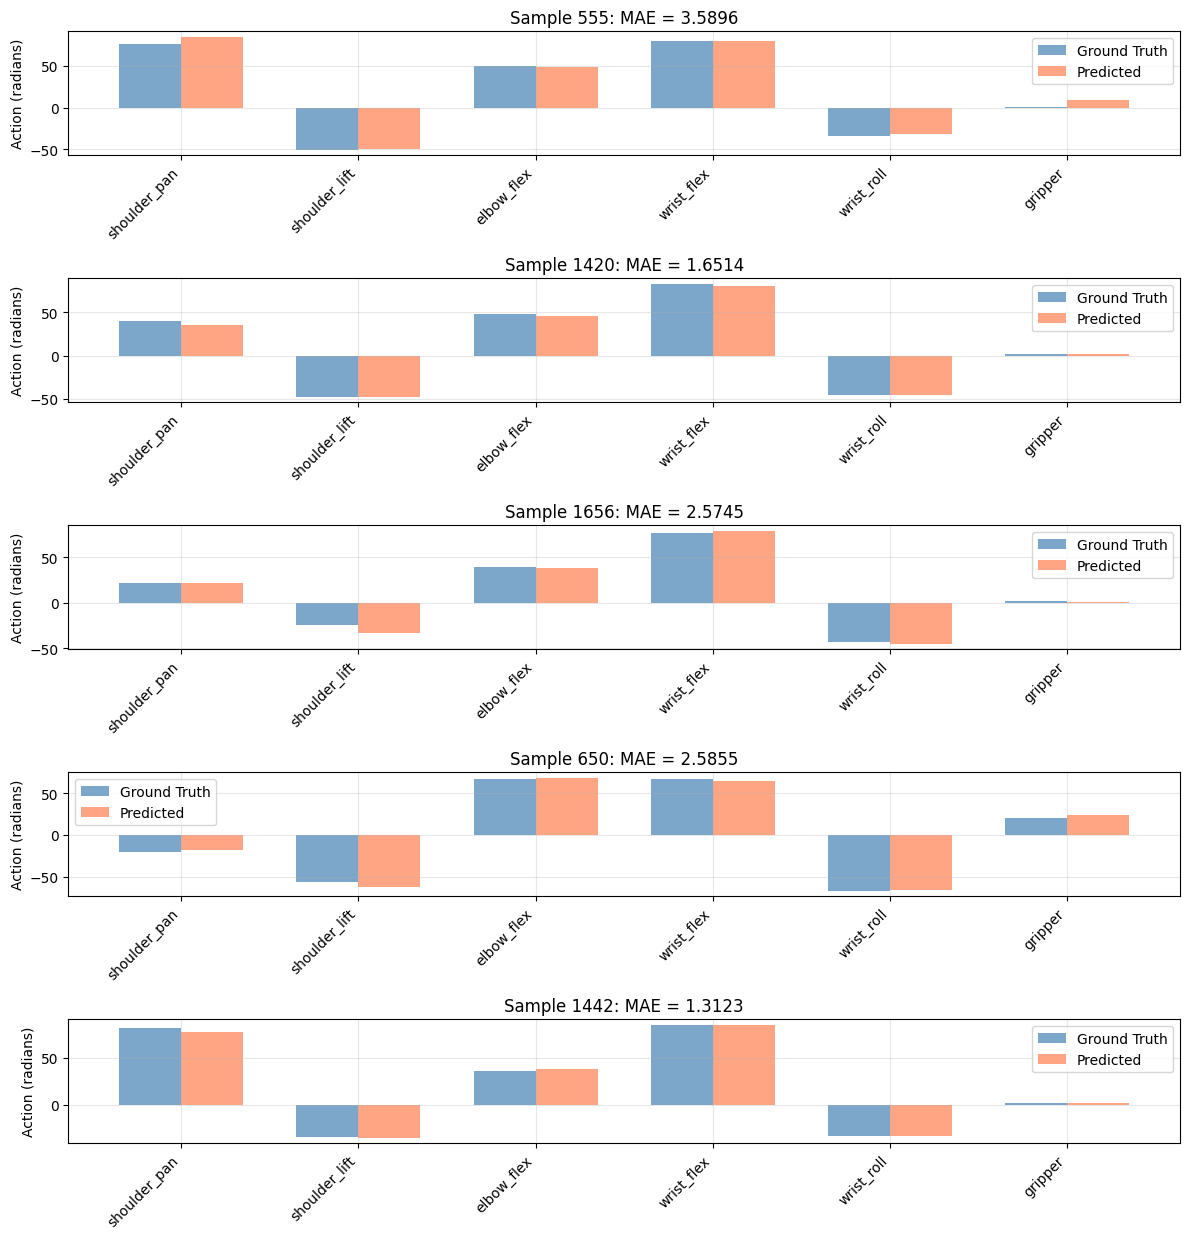


✓ Sample predictions saved to 'prediction_samples.png'


In [75]:
# Visualize actual predictions for a few samples
n_samples = 5
sample_indices = np.random.choice(len(all_preds_raw), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 1, figsize=(12, 2.5*n_samples))
if n_samples == 1:
    axes = [axes]

for i, idx in enumerate(sample_indices):
    pred = all_preds_raw[idx].numpy()
    gt = all_gts_raw[idx].numpy()
    
    x = np.arange(len(joint_names))
    width = 0.35
    
    axes[i].bar(x - width/2, gt, width, label='Ground Truth', alpha=0.7, color='steelblue')
    axes[i].bar(x + width/2, pred, width, label='Predicted', alpha=0.7, color='coral')
    
    axes[i].set_ylabel('Action (radians)')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(joint_names, rotation=45, ha='right')
    axes[i].set_title(f'Sample {idx}: MAE = {torch.abs(all_preds_raw[idx] - all_gts_raw[idx]).mean():.4f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Sample predictions saved to 'prediction_samples.png'")


In [54]:
# eval
all_preds_raw = []
all_gts_raw = []
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy.to(DEVICE).eval()

with torch.no_grad():
    for i, raw in enumerate(val_loader):
        """ ground truth in RAW space (dataset space)"""
        gt_raw = raw["action"][:, 0, :].clone()     # instead of getting all the 50 action (B,T,6), we just get the first action (B,6)

        raw = fix_keys(raw)
        batch = preprocessor(raw)

        for k, v in list(batch.items()):
            if torch.is_tensor(v):
                batch[k] = v.to(DEVICE)

        # model inference to normalised action sequence
        pred_seq = policy.predict_action_chunk(batch)    # (B, 50, 6)
        pred_step0 = pred_seq[:, 0, :].cpu()             # (B,6) normalized

        # bring prediction back to RAW space
        pred_raw = unnormalize_pred(pred_step0)          # (B,6)
        # append the preds and gts to lists
        all_preds_raw.append(pred_raw)
        all_gts_raw.append(gt_raw)


all_preds_raw = torch.cat(all_preds_raw, dim=0)
all_gts_raw   = torch.cat(all_gts_raw, dim=0)

print("Collected preds:", all_preds_raw.shape, "Ground truths:", all_gts_raw.shape)


Collected preds: torch.Size([2389, 6]) Ground truths: torch.Size([2389, 6])


In [55]:
joint_ranges = action_max - action_min
tol = joint_ranges * 0.05     # 5% per joint

abs_err = torch.abs(all_preds_raw - all_gts_raw)   # (N,6)
within_5pr = abs_err <= tol                       # (True/False split)

per_joint_success = within_5pr.float().mean(dim=0) * 100.0
overall_mean = per_joint_success.mean().item()

print("\n========== EVAL (per-joint 5%) ==========")
for j, s in enumerate(per_joint_success):
    print(f"joint {j}: {s:.2f}%")

print(f"\nAverage per-joint success (5%): {overall_mean:.2f}%")
print("=========================================\n")


========== EVAL (per-joint 5%) ==========
joint 0: 98.87%
joint 1: 91.71%
joint 2: 91.54%
joint 3: 90.16%
joint 4: 97.66%
joint 5: 87.15%

Average per-joint success (5%): 92.85%



In [51]:
#!/usr/bin/env python3
"""
SmolVLA Inference Testing Script
Tests the best checkpoint against validation set ground truth
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Configuration
CHECKPOINT_PATH = "/home/saleh/lerobot/src/lerobot_output/smolvla_proper_split_final/checkpoint-6000"
DATASET_NAME = "lerobot/svla_so101_pickplace"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Validation episodes (from your stratified split)
# Replace these with your actual validation episode indices
VAL_EPISODES = [2, 8, 13, 18, 22, 29, 34, 38, 41, 47]  # Example - adjust based on your split

def load_model_and_data():
    """Load trained model and validation dataset"""
    print(f"Loading model from {CHECKPOINT_PATH}...")
    
    # Load the policy
    policy = SmolVLAPolicy.from_pretrained(CHECKPOINT_PATH)
    policy.to(DEVICE)
    policy.eval()
    print(f"✓ Model loaded on {DEVICE}")
    
    # Load full dataset
    print(f"Loading dataset {DATASET_NAME}...")
    dataset = LeRobotDataset(DATASET_NAME, video_backend="pyav")
    print(f"✓ Dataset loaded: {len(dataset)} total samples")
    
    return policy, dataset


def get_validation_indices(dataset, val_episodes):
    """Get dataset indices for validation episodes"""
    episode_idx = np.array(dataset.hf_dataset["episode_index"])
    val_indices = [i for i, ep in enumerate(episode_idx) if ep in val_episodes]
    print(f"✓ Found {len(val_indices)} validation samples across {len(val_episodes)} episodes")
    return val_indices


def run_inference_on_episode(policy, dataset, episode_num):
    """Run inference on a single episode and compare with ground truth"""
    
    # Get all frames from this episode
    episode_idx = np.array(dataset.hf_dataset["episode_index"])
    episode_indices = [i for i, ep in enumerate(episode_idx) if ep == episode_num]
    
    print(f"\nProcessing episode {episode_num} ({len(episode_indices)} frames)...")
    
    predictions = []
    ground_truths = []
    
    with torch.no_grad():
        for idx in episode_indices:
            # Get sample
            sample = dataset[idx]  # Get first chunk
            
            # Prepare input for model
            batch = {
                'observation.images.up': sample['observation.images.up'].unsqueeze(0).to(DEVICE),
                'observation.images.side': sample['observation.images.side'].unsqueeze(0).to(DEVICE),
                'observation.state': sample['observation.state'].unsqueeze(0).to(DEVICE),
            }
            
            # Get prediction
            output = policy.select_action(batch)
            pred_action = output.cpu().numpy().squeeze()
            
            # Get ground truth
            gt_action = sample['action'].numpy()
            
            predictions.append(pred_action)
            ground_truths.append(gt_action)
    
    return np.array(predictions), np.array(ground_truths)


def compute_metrics(predictions, ground_truths):
    """Compute error metrics between predictions and ground truth"""
    
    # Mean Absolute Error (MAE) per joint
    mae_per_joint = np.mean(np.abs(predictions - ground_truths), axis=0)
    
    # Root Mean Square Error (RMSE) per joint
    rmse_per_joint = np.sqrt(np.mean((predictions - ground_truths)**2, axis=0))
    
    # Overall MAE and RMSE
    mae_overall = np.mean(mae_per_joint)
    rmse_overall = np.mean(rmse_per_joint)
    
    # Maximum error per joint
    max_error_per_joint = np.max(np.abs(predictions - ground_truths), axis=0)
    
    return {
        'mae_per_joint': mae_per_joint,
        'rmse_per_joint': rmse_per_joint,
        'mae_overall': mae_overall,
        'rmse_overall': rmse_overall,
        'max_error_per_joint': max_error_per_joint,
    }


def visualize_episode_comparison(predictions, ground_truths, episode_num, save_path=None):
    """Visualize predicted vs ground truth actions for an episode"""
    
    joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll', 'gripper']
    n_joints = predictions.shape[1]
    
    fig, axes = plt.subplots(n_joints, 1, figsize=(12, 2.5*n_joints))
    if n_joints == 1:
        axes = [axes]
    
    for i, (ax, joint_name) in enumerate(zip(axes, joint_names)):
        # Plot ground truth and predictions
        ax.plot(ground_truths[:, i], label='Ground Truth', linewidth=2, alpha=0.8)
        ax.plot(predictions[:, i], label='Predicted', linewidth=2, alpha=0.8, linestyle='--')
        
        # Compute and display error
        mae = np.mean(np.abs(predictions[:, i] - ground_truths[:, i]))
        rmse = np.sqrt(np.mean((predictions[:, i] - ground_truths[:, i])**2))
        
        ax.set_ylabel(f'{joint_name}\n(radians)', fontsize=10)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.set_title(f'{joint_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}', fontsize=10)
    
    axes[-1].set_xlabel('Time Step', fontsize=12)
    fig.suptitle(f'Episode {episode_num}: Predicted vs Ground Truth Actions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved visualization to {save_path}")
    
    plt.show()


def visualize_error_heatmap(all_predictions, all_ground_truths, save_path=None):
    """Visualize error distribution across all validation episodes"""
    
    errors = np.abs(all_predictions - all_ground_truths)
    joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll', 'gripper']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Heatmap of errors
    im = axes[0].imshow(errors.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Joint')
    axes[0].set_yticks(range(len(joint_names)))
    axes[0].set_yticklabels(joint_names)
    axes[0].set_title('Absolute Error Heatmap')
    plt.colorbar(im, ax=axes[0], label='Absolute Error (radians)')
    
    # Box plot of errors per joint
    axes[1].boxplot([errors[:, i] for i in range(errors.shape[1])], labels=joint_names)
    axes[1].set_ylabel('Absolute Error (radians)')
    axes[1].set_xlabel('Joint')
    axes[1].set_title('Error Distribution per Joint')
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved error heatmap to {save_path}")
    
    plt.show()


def generate_summary_report(all_metrics, val_episodes):
    """Generate a text summary of inference results"""
    
    joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll', 'gripper']
    
    print("\n" + "="*70)
    print("INFERENCE EVALUATION SUMMARY")
    print("="*70)
    
    print(f"\nValidated on {len(val_episodes)} episodes: {val_episodes}")
    print(f"Total frames evaluated: {sum([m['n_frames'] for m in all_metrics])}")
    
    # Average metrics across all episodes
    avg_mae_overall = np.mean([m['mae_overall'] for m in all_metrics])
    avg_rmse_overall = np.mean([m['rmse_overall'] for m in all_metrics])
    
    print(f"\n{'OVERALL METRICS':-^70}")
    print(f"Average MAE:  {avg_mae_overall:.4f} radians")
    print(f"Average RMSE: {avg_rmse_overall:.4f} radians")
    
    # Per-joint metrics
    avg_mae_per_joint = np.mean([m['mae_per_joint'] for m in all_metrics], axis=0)
    avg_rmse_per_joint = np.mean([m['rmse_per_joint'] for m in all_metrics], axis=0)
    max_error_per_joint = np.max([m['max_error_per_joint'] for m in all_metrics], axis=0)
    
    print(f"\n{'PER-JOINT METRICS':-^70}")
    print(f"{'Joint':<15} {'MAE':>10} {'RMSE':>10} {'Max Error':>12}")
    print("-" * 70)
    for i, joint_name in enumerate(joint_names):
        print(f"{joint_name:<15} {avg_mae_per_joint[i]:>10.4f} {avg_rmse_per_joint[i]:>10.4f} {max_error_per_joint[i]:>12.4f}")
    
    # Identify best and worst joints
    best_joint_idx = np.argmin(avg_mae_per_joint)
    worst_joint_idx = np.argmax(avg_mae_per_joint)
    
    print(f"\n{'INSIGHTS':-^70}")
    print(f"✓ Best performing joint:  {joint_names[best_joint_idx]} (MAE: {avg_mae_per_joint[best_joint_idx]:.4f})")
    print(f"⚠ Worst performing joint: {joint_names[worst_joint_idx]} (MAE: {avg_mae_per_joint[worst_joint_idx]:.4f})")
    
    # Overall assessment
    print(f"\n{'ASSESSMENT':-^70}")
    if avg_mae_overall < 0.05:
        print("🏆 EXCELLENT: Model predictions are very close to ground truth!")
    elif avg_mae_overall < 0.10:
        print("✓ GOOD: Model predictions are reasonably accurate.")
    elif avg_mae_overall < 0.20:
        print("⚠ FAIR: Model has moderate prediction errors.")
    else:
        print("❌ POOR: Model predictions deviate significantly from ground truth.")
    
    print("="*70 + "\n")


def main():
    """Main inference testing workflow"""
    
    # Create output directory for visualizations
    output_dir = Path("inference_results")
    output_dir.mkdir(exist_ok=True)
    print(f"Output directory: {output_dir}")
    
    # Load model and data
    policy, dataset = load_model_and_data()
    
    # Get validation indices
    val_indices = get_validation_indices(dataset, VAL_EPISODES)
    
    # Run inference on all validation episodes
    all_predictions = []
    all_ground_truths = []
    all_metrics = []
    
    for episode_num in VAL_EPISODES:
        # Run inference
        predictions, ground_truths = run_inference_on_episode(policy, dataset, episode_num)
        
        # Compute metrics
        metrics = compute_metrics(predictions, ground_truths)
        metrics['n_frames'] = len(predictions)
        all_metrics.append(metrics)
        
        # Store for aggregate analysis
        all_predictions.append(predictions)
        all_ground_truths.append(ground_truths)
        
        # Print episode metrics
        print(f"  Episode {episode_num}: MAE={metrics['mae_overall']:.4f}, RMSE={metrics['rmse_overall']:.4f}")
        
        # Visualize first 3 episodes in detail
        if len(all_predictions) <= 3:
            save_path = output_dir / f"episode_{episode_num}_comparison.png"
            visualize_episode_comparison(predictions, ground_truths, episode_num, save_path)
    
    # Concatenate all predictions and ground truths
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_ground_truths = np.concatenate(all_ground_truths, axis=0)
    
    # Generate summary report
    generate_summary_report(all_metrics, VAL_EPISODES)
    
    # Visualize aggregate error heatmap
    heatmap_path = output_dir / "error_heatmap.png"
    visualize_error_heatmap(all_predictions, all_ground_truths, heatmap_path)
    
    # Save numerical results
    results_path = output_dir / "inference_metrics.txt"
    with open(results_path, 'w') as f:
        f.write("Episode,MAE,RMSE,n_frames\n")
        for episode_num, metrics in zip(VAL_EPISODES, all_metrics):
            f.write(f"{episode_num},{metrics['mae_overall']:.6f},{metrics['rmse_overall']:.6f},{metrics['n_frames']}\n")
    print(f"✓ Saved metrics to {results_path}")
    
    print("\n✓ Inference testing complete!")
    print(f"  Results saved to: {output_dir}")


if __name__ == "__main__":
    main()

Output directory: inference_results
Loading model from /home/saleh/lerobot/src/lerobot_output/smolvla_proper_split_final/checkpoint-6000...
Loading  HuggingFaceTB/SmolVLM2-500M-Video-Instruct weights ...
Reducing the number of VLM layers to 16 ...
Loading weights from local directory
✓ Model loaded on cuda
Loading dataset lerobot/svla_so101_pickplace...
✓ Dataset loaded: 11939 total samples
✓ Found 2389 validation samples across 10 episodes

Processing episode 2 (230 frames)...


ValueError: All image features are missing from the batch. At least one expected. (batch: dict_keys(['observation.images.up', 'observation.images.side', 'observation.state'])) (image_features:{'observation.images.camera1': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 256, 256)), 'observation.images.camera2': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 256, 256)), 'observation.images.camera3': PolicyFeature(type=<FeatureType.VISUAL: 'VISUAL'>, shape=(3, 256, 256))})